# Задание

Выберите набор данных (датасет) для решения задачи классификации или регресии.

В случае необходимости проведите удаление или заполнение пропусков и кодирование категориальных признаков.

С использованием метода train_test_split разделите выборку на обучающую и тестовую.

Обучите две ансамблевые модели. Оцените качество моделей с помощью одной из подходящих для задачи метрик. Сравните качество полученных моделей.
Произведите для каждой модели подбор значений одного гиперпараметра. В зависимости от используемой библиотеки можно применять функцию GridSearchCV, использовать перебор параметров в цикле, или использовать другие методы.

Повторите пункт 4 для найденных оптимальных значений гиперпараметров. Сравните качество полученных моделей с качеством моделей, полученных в пункте 4.

# Подготовка набора данных

Набор данных содержит в себе информацию о пациентах и целевым признаком является наличие болезни сердца.

In [35]:
import pandas as pd

In [36]:
df = pd.read_csv('heart.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [37]:
row_number = df.shape[0]
column_number = df.shape[1]

print('Данный датасет содержит {} строки и {} столбцов.'.format(row_number, column_number))

Данный датасет содержит 303 строки и 14 столбцов.


In [38]:
null_flag = False
null_columns = {}
for col in df.columns:
    null_count = df[df[col].isnull()].shape[0]
    if null_count > 0:
        null_flag = True
        column_type = df[col].dtype
        null_columns[col] = column_type
        percent = round((null_count / row_number) * 100, 3)
        print('{} - {} - {}. Тип - {}'.format(col, null_count, percent, column_type))
        
if not null_flag:
    print('Пропуски в данных отсутствуют.')

Пропуски в данных отсутствуют.


In [39]:
obj_flag = False
for col in df.columns:
    column_type = df[col].dtype
    if column_type == 'object':
        obj_flag = True
        print(col)
if not obj_flag:
    print('Категориальные признаки отсутствуют')

Категориальные признаки отсутствуют


In [40]:
grouped_df = (df.groupby('target').count()
              .reset_index()[['target','age']])
grouped_df.columns = ['target','count']
grouped_df['summ'] = df.shape[0]
grouped_df['percent'] = round(grouped_df['count'] / grouped_df['summ'] * 100,2)
grouped_df

,target,count,summ,percent
0,0,138,303,45.54
1,1,165,303,54.46


In [8]:
from sklearn.model_selection import train_test_split

df_x = df.loc[:, df.columns != 'target']
df_y = df['target']
train_x_df, test_x_df, train_y_df, test_y_df = train_test_split(df_x,df_y,
                                     test_size=0.3, random_state=1)

In [9]:
row_number = train_x_df.shape[0]
column_number = train_x_df.shape[1]

print('Тренировочный датасет содержит {} строк и {} столбцов.'.format(row_number, column_number))

Тренировочный датасет содержит 212 строк и 13 столбцов.


In [10]:
row_number = test_x_df.shape[0]
column_number = test_x_df.shape[1]

print('Тестовый датасет содержит {} строк и {} столбцов.'.format(row_number, column_number))

Тестовый датасет содержит 91 строк и 13 столбцов.


# Обучение моделей

## Случайный лес 

### Обучение с произвольным гипер-параметром

In [12]:
from sklearn.ensemble import RandomForestClassifier

tree = RandomForestClassifier(n_estimators=1, 
                               oob_score=False, 
                               random_state=1)
tree.fit(train_x_df, train_y_df)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [13]:
target_t = tree.predict(test_x_df)

### Оценка качества модели с произвольным гиперпараемтром 

In [15]:
from sklearn.metrics import balanced_accuracy_score

accuracy_t = balanced_accuracy_score(test_y_df, 
                              target_t)

'Balanced accuracy score - %0.2f' % accuracy_t

'Balanced accuracy score - 0.72'

In [28]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Отрисовка ROC-кривой
def draw_roc_curve(y_true, y_score, pos_label, average):
    fpr, tpr, thresholds = roc_curve(y_true, y_score, 
                                     pos_label=pos_label)
    roc_auc_value = roc_auc_score(y_true, y_score, average=average)
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc_value)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

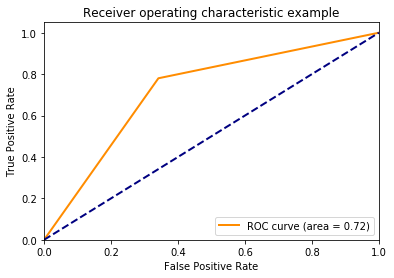

In [31]:
draw_roc_curve(test_y_df, 
               target_t, 
               pos_label=1, average='micro')

### Подбор гиперпараметров 

In [19]:
import numpy as np
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': np.arange(1, 11, 1),
    'random_state': np.arange(1, 11, 1),
}

grid = GridSearchCV(estimator=RandomForestClassifier(),
                    param_grid=params, 
                    scoring='balanced_accuracy', 
                    cv=3, 
                    n_jobs=-1)

grid.fit(train_x_df, train_y_df)

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

### Оценка качества модели с подобранным гипер-параметром 

In [20]:
grid.best_estimator_.fit(train_x_df, train_y_df)
target_t_best = grid.best_estimator_.predict(test_x_df)

In [22]:
from sklearn.metrics import balanced_accuracy_score

accuracy_t_best = balanced_accuracy_score(test_y_df, 
                              target_t_best)

print('Balanced accuracy score - %0.2f' % accuracy_t)
print('Best balanced accuracy score - %0.2f' % accuracy_t_best)

Balanced accuracy score - 0.72
Best balanced accuracy score - 0.76


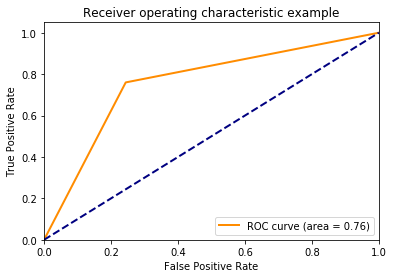

In [30]:
draw_roc_curve(test_y_df, 
               target_t_best, 
               pos_label=1, average='micro')

## Градиентный бустинг 

### Обучение модели спроизвольным гипер-параметром

In [16]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(random_state=1)
gb.fit(train_x_df, train_y_df)

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='deviance', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=100,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=1, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [17]:
target_gb = gb.predict(test_x_df)

### Оценка качества модели с произвольным гипер-параметром 

In [18]:
accuracy_gb = balanced_accuracy_score(test_y_df, 
                              target_gb)

'Balanced accuracy score - %0.2f' % accuracy_gb

'Balanced accuracy score - 0.70'

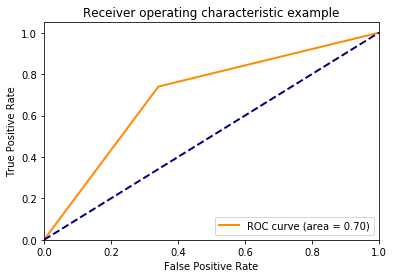

In [34]:
draw_roc_curve(test_y_df, 
               target_gb, 
               pos_label=1, average='micro')

### Подбор гипер-параметров 

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold

parameters = {
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    }

grid_gb = GridSearchCV(estimator=GradientBoostingClassifier(),
                    param_grid=parameters, 
                    scoring='balanced_accuracy', 
                    cv=10,
                       n_jobs=-1
                    )

grid_gb.fit(train_x_df, train_y_df)

GridSearchCV(cv=10, error_score=nan,
             estimator=GradientBoostingClassifier(ccp_alpha=0.0,
                                                  criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=100,
                                                  n_iter_no_...
                 

### Оценка качества модели с подобранным гипер-параметром 

In [41]:
grid_gb.best_estimator_.fit(train_x_df, train_y_df)
target_gb_best = grid_gb.best_estimator_.predict(test_x_df)

In [42]:
from sklearn.metrics import balanced_accuracy_score

accuracy_gb_best = balanced_accuracy_score(test_y_df, 
                              target_gb_best)

print('Balanced accuracy score - %0.2f' % accuracy_gb)
print('Best balanced accuracy score - %0.2f' % accuracy_gb_best)

Balanced accuracy score - 0.70
Best balanced accuracy score - 0.72


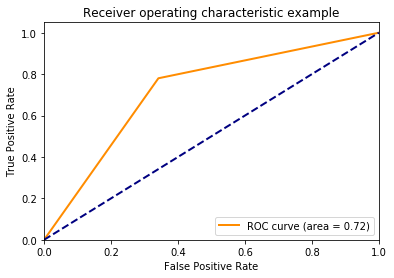

In [43]:
draw_roc_curve(test_y_df, 
               target_gb_best, 
               pos_label=1, average='micro')

# Вывод 

In [44]:
print('Random Forest')
print('Balanced accuracy score - %0.2f' % accuracy_t)
print('Best balanced accuracy score - %0.2f' % accuracy_t_best)
print('Gradient Boosting ')
print('Balanced accuracy score - %0.2f' % accuracy_gb)
print('Best balanced accuracy score - %0.2f' % accuracy_gb_best)

Random Forest
Balanced accuracy score - 0.72
Best balanced accuracy score - 0.76
Gradient Boosting 
Balanced accuracy score - 0.70
Best balanced accuracy score - 0.72


Для используемого набора данных в рамках задачи классификации наилучшей моделью является - случайный лес.